In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE

from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.dummy import DummyClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.random import set_seed

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.decomposition import PCA

from skopt.space import Categorical
from scipy.stats import uniform, loguniform, randint

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler
import pickle

In [2]:
char_df = pd.read_csv('../data/csv/ShakespeareCharacterLines_character_corpus.csv', index_col = ['play', 'name'])

In [3]:
colon = slice(None)

- Baseline accuracy.

In [4]:
char_df['character_dies'].value_counts(normalize = True)

0.0    0.905958
1.0    0.094042
Name: character_dies, dtype: float64

- Train/test split and SMOTE.

In [5]:
char_xlist = char_df.columns.tolist()
char_xlist.remove('character_dies')

char_X = char_df[char_xlist]
char_y = char_df['character_dies']

smt = SMOTE(random_state = 42, k_neighbors = 25, n_jobs = -1)
char_Xsm, char_ysm = smt.fit_resample(char_X, char_y)

char_X_train, char_X_test, char_y_train, char_y_test = \
train_test_split(char_X, char_y, random_state = 42, stratify = char_y, test_size = .2)

char_Xsm_train, char_Xsm_test, char_ysm_train, char_ysm_test = \
train_test_split(char_Xsm, char_ysm, random_state = 42, stratify = char_ysm, test_size = .2)

sc = StandardScaler()

char_Xs_train = sc.fit_transform(char_X_train)
char_Xs_test = sc.transform(char_X_test)
char_Xs = sc.transform(char_X)

char_Xsms_train = sc.fit_transform(char_Xsm_train)
char_Xsms_test = sc.transform(char_Xsm_test)
char_Xsms = sc.transform(char_Xsm)

- PCA on base dataset.

In [6]:
pca = PCA(random_state=42)
char_Z_train = pca.fit_transform(char_Xs_train)

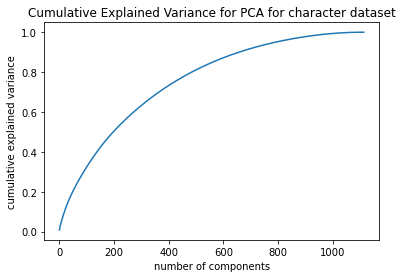

In [7]:
explained_variance = pca.explained_variance_ratio_
plt.plot(np.cumsum(explained_variance))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('Cumulative Explained Variance for PCA for character dataset')
plt.show()

In [8]:
char_pca = PCA(random_state=42, svd_solver='full')
char_Z_train = char_pca.fit_transform(char_Xs_train)
char_Z_test = char_pca.transform(char_Xs_test)
char_Z = char_pca.transform(char_Xs)

- PCA on SMOTE dataset.

In [9]:
pca_sm = PCA(random_state=42)
char_Zsms_train = pca_sm.fit_transform(char_Xsms_train)

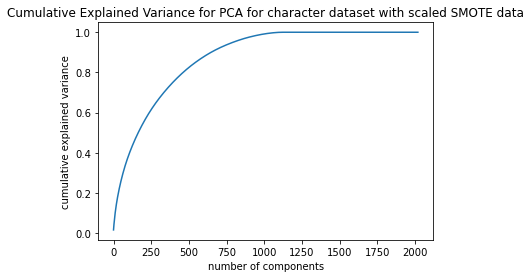

In [10]:
explained_variance = pca_sm.explained_variance_ratio_
plt.plot(np.cumsum(explained_variance))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('Cumulative Explained Variance for PCA for character dataset with scaled SMOTE data')
plt.show()

In [11]:
pca_sm = PCA(random_state=42, n_components=1114)
char_Zsms_train = pca_sm.fit_transform(char_Xsms_train)
char_Zsms_test = pca_sm.transform(char_Xsms_test)

- Basic Multinomial Naive Bayes for later inference.

In [12]:
char_mnb_pipe = MultinomialNB(fit_prior = False)

char_mnb_params = {
    'alpha': uniform(0, 1)
}

char_mnb_rs = RandomizedSearchCV(estimator = char_mnb_pipe,
                     param_distributions = char_mnb_params,
                     scoring = 'roc_auc',
                     n_iter = 50,
                     n_jobs = 8,
                     cv = 5,
                     refit = True,
                     random_state=42)

In [13]:
char_mnb_rs.fit(char_Xsm_train, char_ysm_train)

RandomizedSearchCV(cv=5, estimator=MultinomialNB(fit_prior=False), n_iter=50,
                   n_jobs=8,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D71AA1D340>},
                   random_state=42, scoring='roc_auc')

In [14]:
train_preds = char_mnb_rs.best_estimator_.predict(char_X_train)
test_preds = char_mnb_rs.best_estimator_.predict(char_X_test)

metrics.roc_auc_score(char_y_train, train_preds), metrics.roc_auc_score(char_y_test, test_preds)

(0.9073717494926613, 0.8400729705077532)

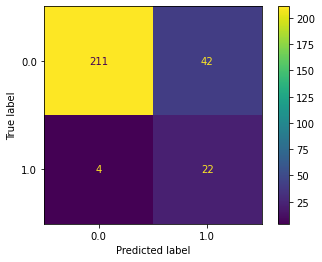

In [15]:
plot_confusion_matrix(char_mnb_rs.best_estimator_, char_X_test, char_y_test)

In [16]:
pickle.dump(char_mnb_rs.best_estimator_, open('../models/CharMultinomialNaiveBayes.pkl', 'wb'))

- Logistic Regression.

In [17]:
logreg_pipe = Pipeline([
    ('sc', StandardScaler()),
    ('logreg', LogisticRegression(random_state = 42, solver = 'saga'))
])

logreg_params = {
    'logreg__penalty': ['l2', 'elastic-net'],
    'logreg__tol': uniform(0, .1),
    'logreg__C': loguniform(0.0001, 100),
    'logreg__class_weight': Categorical(['balanced', None]),
    'logreg__max_iter': randint(1, 1000),
    'logreg__l1_ratio': uniform(0, 1)
}

logreg_rs_rocauc = RandomizedSearchCV(estimator = logreg_pipe,
                     param_distributions = logreg_params,
                     scoring = 'roc_auc',
                     n_iter = 50,
                     n_jobs = 8,
                     cv = 5,
                     refit = True,
                     random_state=42)

In [18]:
%%time
logreg_rs_rocauc.fit(char_Xsms_train, char_ysm_train);

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.98620216        nan        nan 0.98543246 0.98474101 0.98673655
 0.9826123         nan 0.9854815         nan        nan        nan
        nan 0.98488815 0.98357848        nan        nan 0.98641297
        nan 0.9868199  0.98570699 0.98550603 0.98287245        nan
 0.98489305 0.98492736 0.98537854        nan        nan        nan
        nan        nan        nan        nan 0.98535389 0.98534423
 0.98361767 0.9790016  0.98371099 0.98389725        nan        nan
        nan 0.983809          nan 0.98322045        nan        nan
 0.98282307        nan]
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "


Wall time: 26min 50s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('sc', StandardScaler()),
                                             ('logreg',
                                              LogisticRegression(random_state=42,
                                                                 solver='saga'))]),
                   n_iter=50, n_jobs=8,
                   param_distributions={'logreg__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D71AAFFC40>,
                                        'logreg__class_weight': Categorical(categories=('balanced', None), prior=None),
                                        'logreg__l1_ratio': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D71AAFF1F0>,
                                        'logreg__max_iter': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D71AAFF7F0>,
                                        'logreg__penalty': ['l2',
                                                       

In [19]:
train_preds = logreg_rs_rocauc.best_estimator_['logreg'].predict(char_Xs_train)
test_preds = logreg_rs_rocauc.best_estimator_['logreg'].predict(char_Xs_test)

metrics.roc_auc_score(char_y_train, train_preds), metrics.roc_auc_score(char_y_test, test_preds)

(0.9380574826560951, 0.7588932806324111)

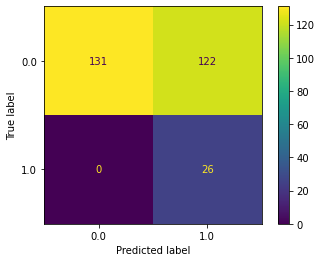

In [20]:
plot_confusion_matrix(logreg_rs_rocauc.best_estimator_['logreg'], char_Xs_test, char_y_test)

In [21]:
pickle.dump(logreg_rs_rocauc.best_estimator_['logreg'], open('../models/CharLogisticRegression.pkl', 'wb'))

- Neural Network with PCA

In [22]:
set_seed(42)
np.random.seed(42)

In [23]:
clear_session()
model = Sequential()

model.add(Dense(35, activation = 'relu', input_shape = (char_Zsms_train.shape[1],), kernel_regularizer = l2(.01)))

layers = 2
for _ in range(0, layers):
    model.add(Dense(35, activation = 'relu', kernel_regularizer = l2(.01)))
    
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam')

early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 2)

history = model.fit(char_Zsms_train, char_ysm_train, validation_data = (char_Zsms_test, char_ysm_test), batch_size = 128, 
                   epochs = 100, verbose = 0, callbacks = [early_stop])

In [24]:
train_preds = model.predict(char_Zsms_train)
test_preds = model.predict(char_Zsms_test)

metrics.roc_auc_score(char_ysm_train, train_preds), metrics.roc_auc_score(char_ysm_test, test_preds)

(1.0, 0.9968787251395946)

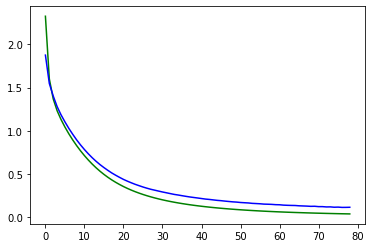

In [25]:
plt.plot(history.epoch, history.history['loss'], c='g');      # green - training loss # Loss
plt.plot(history.epoch, history.history['val_loss'], c='b');  # blue - test loss # Val loss

In [26]:
confusion_matrix(char_ysm_test, np.rint(model.predict(char_Zsms_test)))

array([[238,  15],
       [  0, 252]], dtype=int64)

In [27]:
model.save('../models/')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../models/assets


- SVC

In [28]:
svc_pipe = SVC(random_state = 42, kernel='sigmoid', probability = True,)

svc_params = {
    'gamma': ['scale', 'auto'],
    'class_weight': ['balanced', None],
    'tol': loguniform(0.00001, .1),
    'C': loguniform(0.0001, 100),
    'class_weight': Categorical(['balanced', None]),
    'max_iter': randint(10000, 30000)
}

svc_rs_rocauc = RandomizedSearchCV(estimator = svc_pipe,
                     param_distributions = svc_params,
                     scoring = 'roc_auc',
                     n_iter = 50,
                     n_jobs = 8,
                     cv = 5,
                     refit = True,
                     random_state=42)

In [29]:
%%time
svc_rs_rocauc.fit(char_Zsms_train, char_ysm_train)

Wall time: 13min 17s


RandomizedSearchCV(cv=5,
                   estimator=SVC(kernel='sigmoid', probability=True,
                                 random_state=42),
                   n_iter=50, n_jobs=8,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D76A5AA9D0>,
                                        'class_weight': Categorical(categories=('balanced', None), prior=None),
                                        'gamma': ['scale', 'auto'],
                                        'max_iter': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D76A5AABE0>,
                                        'tol': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D7A7B3AEB0>},
                   random_state=42, scoring='roc_auc')

In [30]:
svc_rs_rocauc.best_estimator_

SVC(C=8.092609705736072, kernel='sigmoid', max_iter=15530, probability=True,
    random_state=42, tol=0.0004673518999562748)

In [31]:
train_preds = svc_rs_rocauc.best_estimator_.predict(char_Zsms_train)
test_preds = svc_rs_rocauc.best_estimator_.predict(char_Zsms_test)

metrics.roc_auc_score(char_ysm_train, train_preds), metrics.roc_auc_score(char_ysm_test, test_preds)

(1.0, 0.992094861660079)

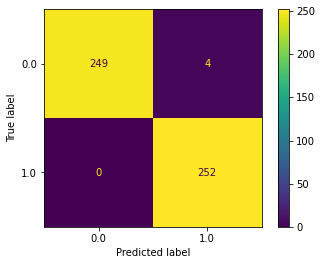

In [32]:
plot_confusion_matrix(svc_rs_rocauc.best_estimator_, char_Zsms_test, char_ysm_test)

In [33]:
pickle.dump(svc_rs_rocauc.best_estimator_, open('../models/CharPCASVC.pkl', 'wb'))

- On to step 6->